In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from random import uniform
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )
    def forward(self,x):
        x=self.net(x)
        return x
    def init_bias(self):
        for layer in self.net.children():
            if isinstance(layer, nn.Linear):
                # 权重采用Xavier正态初始化
                nn.init.xavier_normal_(layer.weight, gain=5 / 3)
                # 偏置置0
                nn.init.constant_(layer.bias, 0.)

In [3]:
def u_function(x, t):
    u = model(torch.hstack((x, t)))
    return u

def f_function(x, t, D = 1):
    u = u_function(x, t)
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]
    R = torch.exp(-t) * (3 / 2 * torch.sin(2 * x) + 8 / 3 * torch.sin(3 * x) + 15 / 4 * torch.sin(4 * x) + 63 / 8 * torch.sin(8 * x))
    f = u_t - D * u_xx - R
    return f

def Loss(u, x_u, t_u, x_f, t_f):
    u_pre = u_function(x_u, t_u)
    f_pre = f_function(x_f, t_f)
    # loss
    null =  torch.zeros((x_f.shape[0], 1))
    u_loss = loss_fn(u_pre, u)
    f_loss = loss_fn(f_pre, null)
    ls = u_loss + f_loss
    ls.backward()
    return ls, u_loss, f_loss
    

In [4]:
# 制造数据点集，要求区分边界点X_u_train和内点X_f_train
N_u = 100
N_f = 10000

# 边界点
x_upper = np.ones((N_u // 4, 1), dtype=float) * np.pi
x_lower = np.ones((N_u // 4, 1), dtype=float) * np.pi * (-1)
t_zero = np.zeros((N_u // 2, 1), dtype=float)

t_upper = np.random.rand(N_u // 4, 1)
t_lower = np.random.rand(N_u // 4, 1)
x_zero = (np.random.rand(N_u // 2, 1) * 2 - 1) * np.pi

X_upper = np.hstack((x_upper, t_upper))
X_lower = np.hstack((x_lower, t_lower))
X_zero = np.hstack((x_zero, t_zero))

X_u_train = np.vstack((X_upper, X_lower, X_zero))
index = np.arange(0, N_u)
np.random.shuffle(index)
X_u_train = X_u_train[index, :]

# 内点
X_f_train = np.zeros((N_f, 2), dtype=float)
for row in range(N_f):
    x = uniform(-np.pi, np.pi)
    t = uniform( 0, 1)
    X_f_train[row, 0] = x 
    X_f_train[row, 1] = t
X_f_train = np.vstack((X_f_train, X_u_train))

# 边界条件
u_upper =  np.zeros((N_u//4, 1), dtype=float)
u_lower =  np.zeros((N_u//4, 1), dtype=float) 
u_zero = np.sin(x_zero) + np.sin(2*x_zero) / 2 + np.sin(3*x_zero) / 3 + np.sin(4*x_zero) / 4 + np.sin(8*x_zero) / 8
u_train = np.vstack((u_upper, u_lower, u_zero))
u_train = u_train[index, :]

[Epoch 1/2000] [loss: 18.34478759765625]
[Epoch 101/2000] [loss: 12.160765647888184]
[Epoch 201/2000] [loss: 6.69202995300293]
[Epoch 301/2000] [loss: 4.7720947265625]
[Epoch 401/2000] [loss: 4.052801132202148]
[Epoch 501/2000] [loss: 2.0345442295074463]
[Epoch 601/2000] [loss: 0.49662208557128906]
[Epoch 701/2000] [loss: 0.2297162413597107]
[Epoch 801/2000] [loss: 0.16457416117191315]
[Epoch 901/2000] [loss: 0.096167653799057]
[Epoch 1001/2000] [loss: 0.05723850056529045]
[Epoch 1101/2000] [loss: 0.047282107174396515]
[Epoch 1201/2000] [loss: 0.04049703851342201]
[Epoch 1301/2000] [loss: 0.03536666929721832]
[Epoch 1401/2000] [loss: 0.031378183513879776]
[Epoch 1501/2000] [loss: 0.028224140405654907]
[Epoch 1601/2000] [loss: 0.025674741715192795]
[Epoch 1701/2000] [loss: 0.023566177114844322]
[Epoch 1801/2000] [loss: 0.021787576377391815]
[Epoch 1901/2000] [loss: 0.02026357129216194]


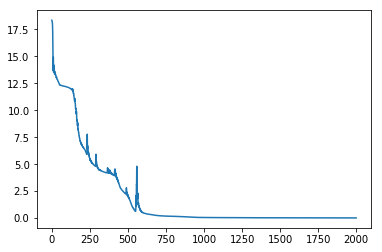

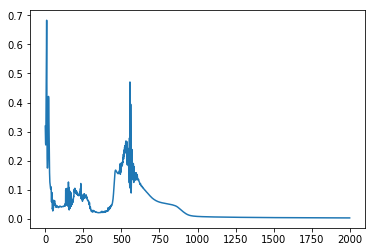

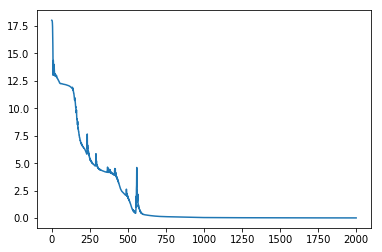

In [5]:
# 模型训练
model=MLP()
loss_fn = nn.MSELoss()  #均方差做损失函数

x_u = torch.tensor(X_u_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_u = torch.tensor(X_u_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

x_f = torch.tensor(X_f_train[:, 0].reshape(-1, 1), dtype=torch.float32, requires_grad=True)
t_f = torch.tensor(X_f_train[:, 1].reshape(-1, 1), dtype=torch.float32, requires_grad=True)

u = torch.tensor(u_train, dtype=torch.float32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9, verbose=False) # 动态递减学习率
epochs = 2000
Losses = []
ULosses = []
FLosses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    loss,uloss,floss = Loss(u, x_u, t_u, x_f, t_f)
    Losses.append(loss.item())
    ULosses.append(uloss.item())
    FLosses.append(floss.item())
    if epoch % 100 ==0:
        print(f"[Epoch {epoch+1}/{epochs}] [loss: {loss.item()}]")
    optimizer.step()
    scheduler.step()
plt.plot(Losses)
plt.show()
plt.plot(ULosses)
plt.show()
plt.plot(FLosses)
plt.show()

E:\anaconda3\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


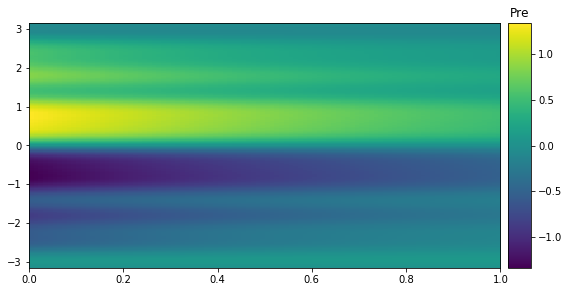

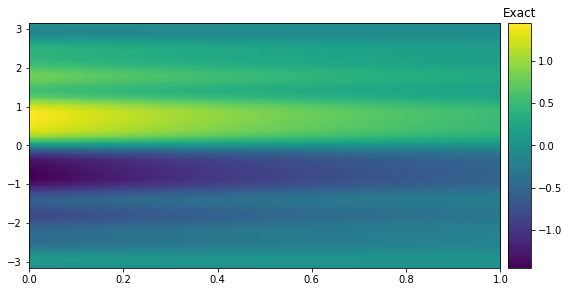

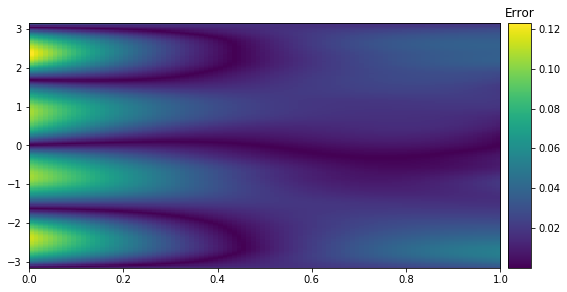

In [6]:
x = torch.linspace(-torch.pi, torch.pi, 200, dtype=torch.float32)
t = torch.linspace(0, 1, 100, dtype=torch.float32)
X, T = torch.meshgrid(x, t)
xcol = X.reshape(-1, 1)
tcol = T.reshape(-1, 1)
u_pre = u_function(xcol, tcol).reshape(x.numel(), t.numel())
xnp = x.numpy()
tnp = t.numpy()
Unp = u_pre.detach().numpy()
# Pre plot:
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Unp,
              interpolation='nearest',
              cmap='viridis', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.title('Pre')
plt.show()
# Exact plot:
def Exact_u(x, t):
    u = torch.exp(-t) * (torch.sin(x) + torch.sin(2*x) / 2 + torch.sin(3*x) / 3 + torch.sin(4*x) / 4 + torch.sin(8*x) / 8)
    return u
u_exact = Exact_u(xcol, tcol).reshape(x.numel(), t.numel())
Uex = u_exact.detach().numpy()

fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Uex,
              interpolation='nearest',
              cmap='viridis', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.title('Exact')
plt.show()
# Error plot
Uerror = np.abs(Unp - Uex)
fig = plt.figure(figsize=(9, 4.5))
ax = fig.add_subplot(111)

h = ax.imshow(Uerror,
              interpolation='nearest',
              cmap='viridis', 
              extent=[tnp.min(), tnp.max(), xnp.min(), xnp.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax) # 新建一个坐标轴，右侧
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=10)
plt.title('Error')
plt.show()

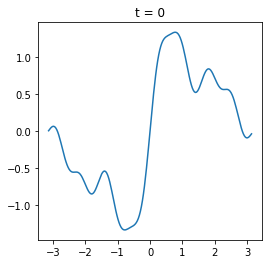

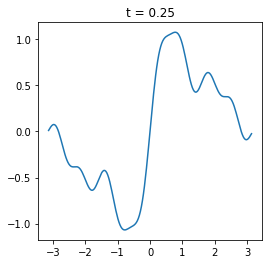

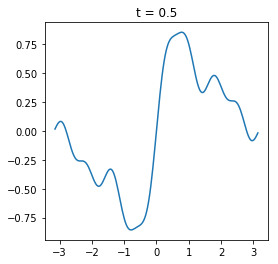

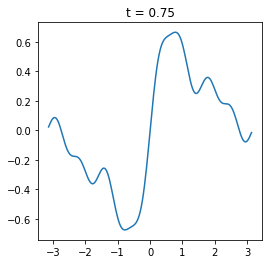

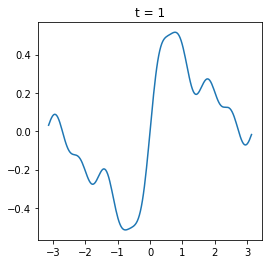

In [7]:
def plot_t(m):
    x = torch.linspace(-torch.pi, torch.pi, 200, dtype=torch.float32).reshape(-1, 1)
    t = torch.full_like(x, m, dtype=torch.float32).reshape(-1, 1)
    u_pre = u_function(x, t).detach().numpy().reshape(-1, 1)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(x,u_pre)
    title = 't = ' + str(m)
    plt.title(title)
    plt.show()
plot_t(0)
plot_t(0.25)
plot_t(0.5)
plot_t(0.75)
plot_t(1)

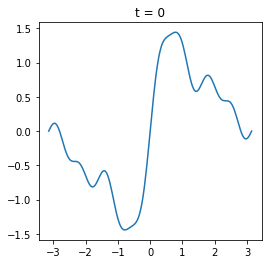

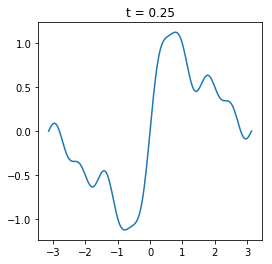

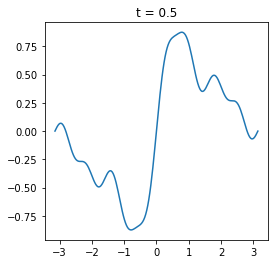

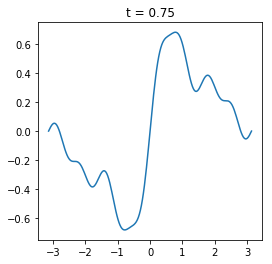

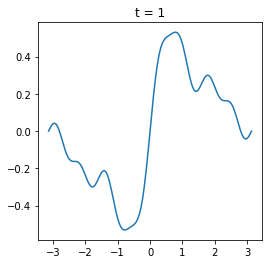

In [12]:
def plot_t(m):
    x = torch.linspace(-torch.pi, torch.pi, 200, dtype=torch.float32).reshape(-1, 1)
    t = torch.full_like(x, m, dtype=torch.float32).reshape(-1, 1)
    u_pre = Exact_u(x, t).detach().numpy().reshape(-1, 1)
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.plot(x,u_pre)
    title = 't = ' + str(m)
    plt.title(title)
    plt.show()
plot_t(0)
plot_t(0.25)
plot_t(0.5)
plot_t(0.75)
plot_t(1)